In [26]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split


In [2]:
tfk = tf.keras
tfkl = tf.keras.layers




In [3]:
x, y = make_classification(n_samples=1000, n_features=3, n_informative=2,
                           n_redundant=0, n_repeated=1, n_clusters_per_class=2,
                           random_state=43, n_classes=2, flip_y=.2)

x.shape, y.shape



((1000, 3), (1000,))

In [4]:
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x)
x_pca.shape



(1000, 2)

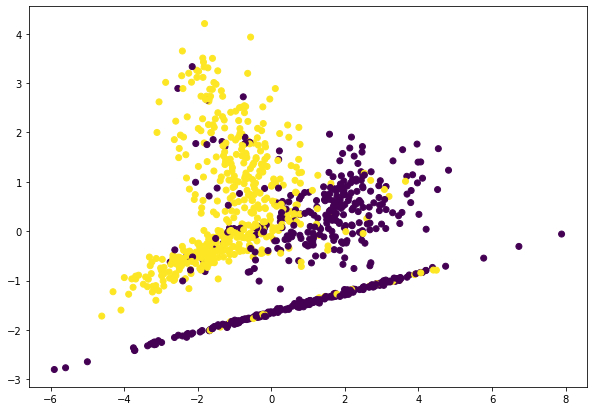

In [5]:
fig = plt.figure(figsize=(10, 7))
plt.scatter(x_pca[:, 0], x_pca[:,1], c=y )
plt.show()


### Train and test split

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.4)

x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=.5)


In [7]:
x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape



((600, 3), (200, 3), (200, 3), (600,), (200,), (200,))

### GaussianNB


In [8]:
np.random.seed(42)
gnb = GaussianNB()

gnb.fit(x_train, y_train)

y_preds_gnb = gnb.predict_proba(x_test)
y_preds_gnb.shape




(200, 2)

### Simple MLP

In [9]:
encoder = OneHotEncoder(sparse=False)

y_train_onehot = encoder.fit_transform(y_train.reshape(-1, 1))
y_val_onehot = encoder.fit_transform(y_val.reshape(-1, 1))
y_test_onehot = encoder.fit_transform(y_test.reshape(-1, 1))




y_train_onehot.shape, y_val_onehot.shape, y_test_onehot.shape

((600, 2), (200, 2), (200, 2))

In [10]:
gnb_roc_auc = roc_auc_score(y_true=y_test_onehot, y_score=y_preds_gnb)
gnb_roc_auc



0.8483

In [11]:
n_units = 10

model_mlp = tf.keras.Sequential([
    tfkl.Dense(units=n_units, input_shape=(x.shape[1],),
               activation='relu', name="dense1"),
    tfkl.Dense(units=n_units, activation='relu', name="dense2"),
    tfkl.Dense(2)
])



In [12]:
optimizer = tfk.optimizers.Adam(learning_rate=1e-4)



In [13]:
loss = tfk.losses.BinaryCrossentropy(from_logits=True)  # binaryclass
# loss = tfk.losses.CategoricalCrossentropy(from_logits=True)  # multiclass



In [14]:
model_mlp.compile(optimizer=optimizer, loss=loss)



In [15]:
model_mlp.fit(x=x_train, y=y_train_onehot, validation_data=(x_val, y_val_onehot), 
          epochs=1000, verbose=True)



Epoch 1/1000
19/19 [==============================] - 1s 11ms/step - loss: 0.7311 - val_loss: 0.7267
Epoch 2/1000
19/19 [==============================] - 0s 5ms/step - loss: 0.7262 - val_loss: 0.7221
Epoch 3/1000
19/19 [==============================] - 0s 7ms/step - loss: 0.7213 - val_loss: 0.7175
Epoch 4/1000
19/19 [==============================] - 0s 6ms/step - loss: 0.7166 - val_loss: 0.7130
Epoch 5/1000
19/19 [==============================] - 0s 4ms/step - loss: 0.7119 - val_loss: 0.7086
Epoch 6/1000
19/19 [==============================] - 0s 5ms/step - loss: 0.7074 - val_loss: 0.7043
Epoch 7/1000
19/19 [==============================] - 0s 5ms/step - loss: 0.7028 - val_loss: 0.7002
Epoch 8/1000
19/19 [==============================] - 0s 7ms/step - loss: 0.6984 - val_loss: 0.6960
Epoch 9/1000
19/19 [==============================] - 0s 3ms/step - loss: 0.6940 - val_loss: 0.6919
Epoch 10/1000
19/19 [==============================] - 0s 6ms/step - loss: 0.6897 - val_loss: 0.687

In [17]:
y_preds_mlp = tf.nn.softmax(model_mlp.predict(x_test)).numpy()
y_preds_mlp.shape



(200, 2)

In [19]:
mlp_roc_auc = roc_auc_score(y_true=y_test_onehot, y_score=y_preds_mlp)

mlp_roc_auc



0.8681000000000001

In [25]:
len(model_mlp.trainable_weights)

6

In [20]:
for w in model_mlp.trainable_weights:
    print(w)

<tf.Variable 'dense1/kernel:0' shape=(3, 10) dtype=float32, numpy=
array([[ 0.40010953, -0.41869596,  0.3872409 ,  0.6339314 ,  0.02000684,
        -0.72116834,  0.44899425,  0.521288  , -0.37868267, -0.04289718],
       [-0.14747795, -0.01589737,  0.6410576 ,  0.54701185,  0.7228964 ,
        -0.40148357,  0.32822928, -0.5688215 ,  0.785541  ,  0.7928799 ],
       [ 0.15739234, -0.6412508 , -0.41399148,  0.31414825, -0.32469064,
        -0.29434687, -0.5002814 ,  0.6655727 ,  0.0769121 , -0.47171316]],
      dtype=float32)>
<tf.Variable 'dense1/bias:0' shape=(10,) dtype=float32, numpy=
array([-0.2223366 ,  0.33233944, -0.08252855,  0.32920402, -0.34310734,
        0.20518464, -0.31946757,  0.38107815, -0.29047304,  0.06505827],
      dtype=float32)>
<tf.Variable 'dense2/kernel:0' shape=(10, 10) dtype=float32, numpy=
array([[-0.2555693 ,  0.24052712, -0.42084065, -0.35026658, -0.32017782,
        -0.08173916, -0.51765215, -0.48730332, -0.41414648,  0.47724456],
       [ 0.25676352,  0.

### Other deep ML

useful question: https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw


**In sum,** for most problems, one could probably get decent performance (even without a second optimization step) by setting the hidden layer configuration using just two rules: (i) number of hidden layers equals one; and (ii) the number of neurons in that layer is the mean of the neurons in the input and output layers.

**Pruning the NN** 


**Linearly Separable data TEST:** https://stats.stackexchange.com/questions/182329/how-to-know-whether-the-data-is-linearly-separable

### Conv NN (not applicable because of data type)

In [69]:
# model_conv = tfk.models.Sequential([
#     tfkl.Conv1D(filters=n_units, kernel_size=3, 
#                 padding="same", activation="relu", 
#                input_shape=(x.shape[1], )),
#     tfkl.Dense(units=n_units, activation="relu"),
#     tfkl.Dense(units=2),
# ])


# model_conv.compile(optimizer=optimizer, loss=loss,)

# model_conv.fit(x=x_train,y=y_train_onehot, 
#                validation_data=(x_val, y_val_onehot),
#                epochs=1000, verbose=True)


### RNN (not applicable because of data type)

In [73]:
# model_rnn = tfk.models.Sequential([
#     tfkl.LSTM(units=n_units, return_sequences=True, input_shape=(x.shape[1], )),
#     tfkl.Dense(units=2),
# ])

